In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt

In [2]:
# The data includes all features
df = pd.read_csv("../clean_data.csv", index_col=0)

In [3]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,3,2,4,...,0,0,0,0,1,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,2,2,4,...,0,0,0,0,1,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,3,2,4,...,0,0,0,0,1,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,2,2,3,...,0,0,0,0,1,0,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,3,2,4,...,0,0,0,0,1,0,0,0,1,0


In [8]:
# Extract the training and test data
X = df.drop("SalePrice", axis=1)
y = np.log(df['SalePrice'])

## Fit and Optimise Models

Linear Regression:

* sklearn.linear_model.Ridge
* sklearn.linear_model.Lasso
* sklearn.linear_model.ElasticNet

Support Vector Machines:

* sklearn.svm.LinearSVR
* sklearn.svm.SVR

Nearest Neighbours:

* sklearn.neighbors.KNearestNeighborsRegressor

Tree Based:

* sklearn.ensemble.RandomForestRegressor
* sklearn.ensemble.GradientBoostingRegressor
* xgboost.XGBRegressor

In [10]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [11]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer, n_jobs = 8,
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

## ElasticNet

Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------
ElasticNet(alpha=0.0004, copy_X=True, fit_intercept=True,
      l1_ratio=0.7000000000000001, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9334367025323651
rmse= 0.10305803329016824
cross_val: mean= 0.13749337315391985 , std= 0.029826999439190014


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   22.3s
[Parallel(n_jobs=8)]: Done 405 out of 405 | elapsed:   34.6s finished


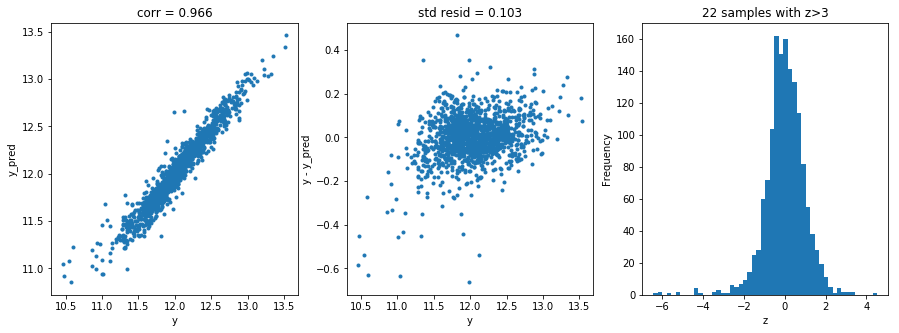

In [15]:
en_int = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}
# param_grid = {'l1_ratio': np.arange(0.1,1.0,0.1),
#               'max_iter':[100000]}


en_int, cv_score, grid_results = train_model(en_int, X=X, y=y, param_grid=param_grid, splits=5, repeats=1)

## Random Forest Regression

Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=75, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
----------------------
score= 0.9720462209003371
rmse= 0.06678588735999963
cross_val: mean= 0.1384288608747139 , std= 0.016949145962406615


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:   19.7s finished


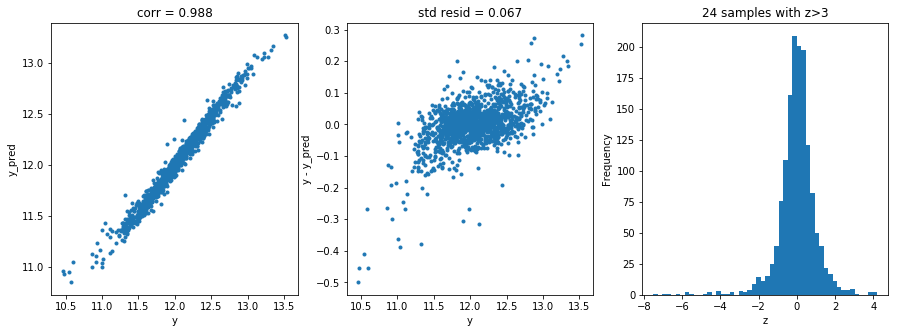

In [13]:
rfr = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

rfr, cv_score, grid_results = train_model(rfr, X=X, y=y,param_grid=param_grid, 
                                              splits=5, repeats=1)